In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 19 14:44:20 2023

@author: guksundo59
"""

"""

Anomaly Detection in Time Series Data with Keras

Project Objective:
    Design and Build an LSTM Autoencoder in Keras
    Detect anomalies (sudden price changes) in the S&P 500 index
    Data range: 1986 - 2020

The dataset is a CSV format with: 
    1. Daily timestamp
    2. Daily Open and Close Price
    3. Daily High and Low Price
    4. Volume


1: Project Overview and Import Libraries
2: Load and Inspect the S&P 500 Index Data
3: Data Preprocessing
4: Temporalize Data and Create Training and Test Splits
5: Build an LSTM Autoencoder
6: Train the Autoencoder
7: Plot Metrics and Evaluate the Model
8: Detect Anomalies in the S&P 500 Index Data
9: Visualize the Anomalies based on threshold

"""

'\n\nAnomaly Detection in Time Series Data with Keras\n\nProject Objective:\n    Design and Build an LSTM Autoencoder in Keras\n    Detect anomalies (sudden price changes) in the S&P 500 index\n    Data range: 1986 - 2020\n\nThe dataset is a CSV format with: \n    1. Daily timestamp\n    2. Daily Open and Close Price\n    3. Daily High and Low Price\n    4. Volume\n\n\n1: Project Overview and Import Libraries\n2: Load and Inspect the S&P 500 Index Data\n3: Data Preprocessing\n4: Temporalize Data and Create Training and Test Splits\n5: Build an LSTM Autoencoder\n6: Train the Autoencoder\n7: Plot Metrics and Evaluate the Model\n8: Detect Anomalies in the S&P 500 Index Data\n9: Visualize the Anomalies based on threshold\n\n'

In [2]:
"""
1. Importing Libraries

"""

#Libraries Needed 
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objs as go


np.random.seed(1)
tf.random.set_seed(1)
pd.options.mode.chained_assignment = None #remove warnings
sns.set(style = 'whitegrid', palette = 'muted')
rcParams['figure.figsize'] = 14, 8 #Setting default figure size

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.8.1


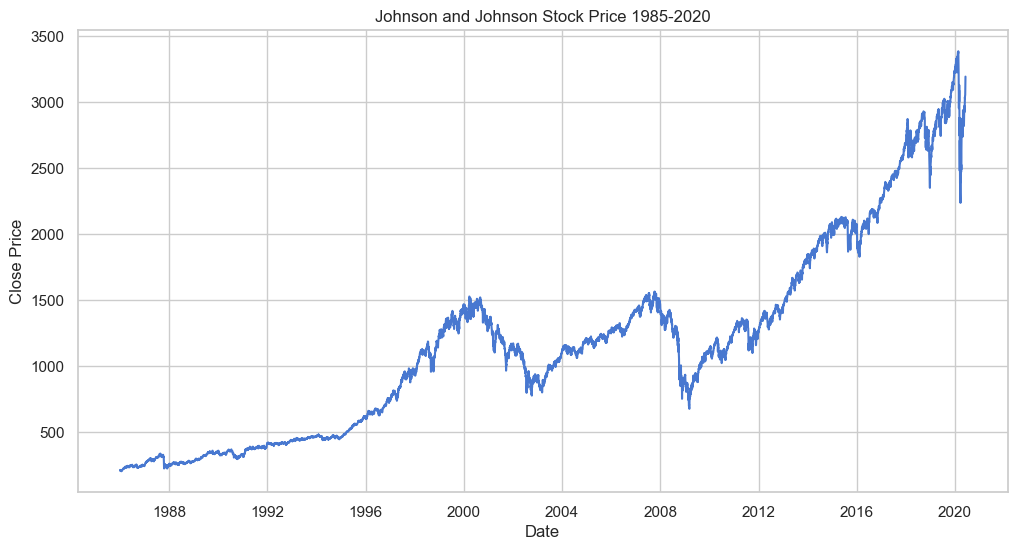

In [3]:
"""
2. Loading and Inspecting the Dataset:

The Dataset is a time series with daily un-adjusted closing price for the S&P 500 Index.
The S&P 500 is a stock performance indicator for the Top 500 companies listed on the stock exchange in the United States. 
It is considered as one of the best representations of the United States stock market. 

- Source of Dataset: Yahoo Finance

"""

#Adjust file path

file = r'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=504921600&period2=1591574400&interval=1d&events=history'
df = pd.read_csv(file, parse_dates = ['Date'] ) #Parse Date column dates to pandas date format
df.head() #Lets see the dataframe
#We are only interested in Date and Close columns. Lets drop the rest
df = df.drop(['Open', 'Adj Close', 'High', 'Volume', 'Low'], axis = 1) 
df.head() #Lets see the dataframe
df.shape #Lets see how many rows and columns are in the dataframe

#Plotting Close Price vs Date for the Dataset
def plot_date_close():
    plt.figure(figsize=(12, 6))
    plt.plot(df.Date, df.Close)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Johnson and Johnson Stock Price 1985-2020')
    plt.show()

plot_date_close() #Show plot

In [4]:
"""

3. Data Preprocessing

"""

train_size = int(len(df) * 0.80) #80% of the dataframe will be used for training
test_size = len(df) - train_size #20% of the dataframe will be used for testing
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)] #We use iloc method to specify the slicing by index
print(train.shape, test.shape) #Lets see the shape of the train and test sets.


from sklearn.preprocessing import StandardScaler #Import StandardScaler to normalize the price data in the training data

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']]) #We use StandardScaler to learn the properties of the Close column by fitting

train['Close'] = scaler.transform(train[['Close']]) #Transforming the 'Close' column in train data.
test['Close'] = scaler.transform(test[['Close']]) #transforming the 'Close' column in test data.

(6942, 2) (1736, 2)


In [5]:
"""

4. Create Training and Test Splits

"""

#We need to temporalize our data
#LSTM Networks require the input data to be in the shape of (n_samples x n_timesteps x n_features)
#n_features = 1 and n_timesteps = 30 (days)
#This process needs to be done on X_train, y_train, X_test and y_test
#defining a function that would do the process is efficient
def create_sequence(X, y, time_steps = 1):
    
    Xs, ys = [], [] #empty lists   
    for i in range (len(X) - time_steps): #looping through data using time_steps
        Xs.append(X.iloc[i:(i + time_steps)].values) #Append values from i to i+time_steps to Xs list
        ys.append(y.iloc[i + time_steps]) ##Append from i to time_st|eps to ys list
        
    return np.array(Xs), np.array(ys) #Convert lists to numpy arrays and return 
    

X_train, y_train = create_sequence(train[['Close']], train.Close, time_steps = 30)
X_test, y_test = create_sequence(test[['Close']], test.Close, time_steps = 30)

#Lets check the shapes of our data split
print(X_train.shape) #should be n_samples, n_timesteps, n_features
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6912, 30, 1)
(6912,)
(1706, 30, 1)
(1706,)


In [6]:
"""

5. Building an LSTM Autoencoder

"""

#Build an LSTM Autoencoder Network
#Visualize the Network architecture and data flow

#To get an autoencoder to detect anomalies
#1. Train autoencoder on data without anomalies (normal data)
#2. Take a datapoint and reconstruct it and calculate the reconstruction error.
#3. If reconstructed point has an error above an assigned threshold. It is labeled as an Anomaly. 

#Setting parameters
timesteps = X_train.shape[1] #This is 30 in X_train
n_features = X_train.shape[2] #number of features is 1
print("Timesteps = ", timesteps)
print("Number of features = ", n_features)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

#Building the LSTM Autoencoder model function
def LSTM_Autoencoder():
    
    model = Sequential()
    #Each input in data sample is a 2D array that will be fed to LSTM Network layer
    #The output of the layer will be an encoded feature vector of the input data
    
    #Input shape is 2D array timesteps x n_features. 
    #First layer will have 128 neurons
    model.add(LSTM(128, input_shape = (timesteps, n_features)))
    
    #Dropout regularization. 20% of neurons
    model.add(Dropout(0.2))
    
    #When second hidden layer is LSTM:
    #The encoded feature vector ouput must be replicated * timesteps 
    model.add(RepeatVector(timesteps))
    
    #Decoder layer
    #We set return_sequences to True. Each neuron will give a signal per timestep
    model.add(LSTM(128, return_sequences = True))
    
    #Dropout regularizaiton
    model.add(Dropout(0.2))
    
    #To use TimeDistributedlayer, return sequences from previous LSTM layer must be set to True
    #This is the output layer. It will create a vector with length of previous LSTM neurons
    model.add(TimeDistributed(Dense(n_features)))
    

    #Compiling using mean absolute error as the loss function 
    #Adam' optimizer for gradient descent with default learning rate
    model.compile(loss = 'mae', optimizer = 'adam')

    return model


#Initializing the model
model = LSTM_Autoencoder()
#Lets see the model summary
model.summary()

Timesteps =  30
Number of features =  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)        

In [7]:
"""

6. Train the Autoencoder

"""
#Configure a training Early Stopper to monitor the validation loss for improvements
#The stopper will stop training when the loss did not decrease for 6 consecutive epochs
ES = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')

#Model Checkpoint callback. Method used to save the best model observed during training.
MC = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

callbacks_list = [ES, MC]

#Validation split of the train data at 10%.
#Shuffle set to False since order of data is important (Time series Data)
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, 
                    validation_split = 0.2, callbacks = callbacks_list, shuffle = False)

Epoch 1/100


2023-06-19 17:33:16.662095: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


173/173 [==============================] - 7s 34ms/step - loss: 0.1702 - val_loss: 0.1288
Epoch 2/100
173/173 [==============================] - 6s 34ms/step - loss: 0.1103 - val_loss: 0.0978
Epoch 3/100
173/173 [==============================] - 6s 35ms/step - loss: 0.0968 - val_loss: 0.0830
Epoch 4/100
173/173 [==============================] - 6s 35ms/step - loss: 0.1055 - val_loss: 0.0782
Epoch 5/100
173/173 [==============================] - 6s 35ms/step - loss: 0.1050 - val_loss: 0.0754
Epoch 6/100
173/173 [==============================] - 6s 36ms/step - loss: 0.1059 - val_loss: 0.0831
Epoch 7/100
173/173 [==============================] - 6s 35ms/step - loss: 0.1108 - val_loss: 0.0936
Epoch 8/100
173/173 [==============================] - 6s 35ms/step - loss: 0.1288 - val_loss: 0.1061
Epoch 9/100
173/173 [==============================] - 6s 35ms/step - loss: 0.1266 - val_loss: 0.1176
Epoch 10/100
173/173 [==============================] - 6s 35ms/step - loss: 0.1206 - val_loss

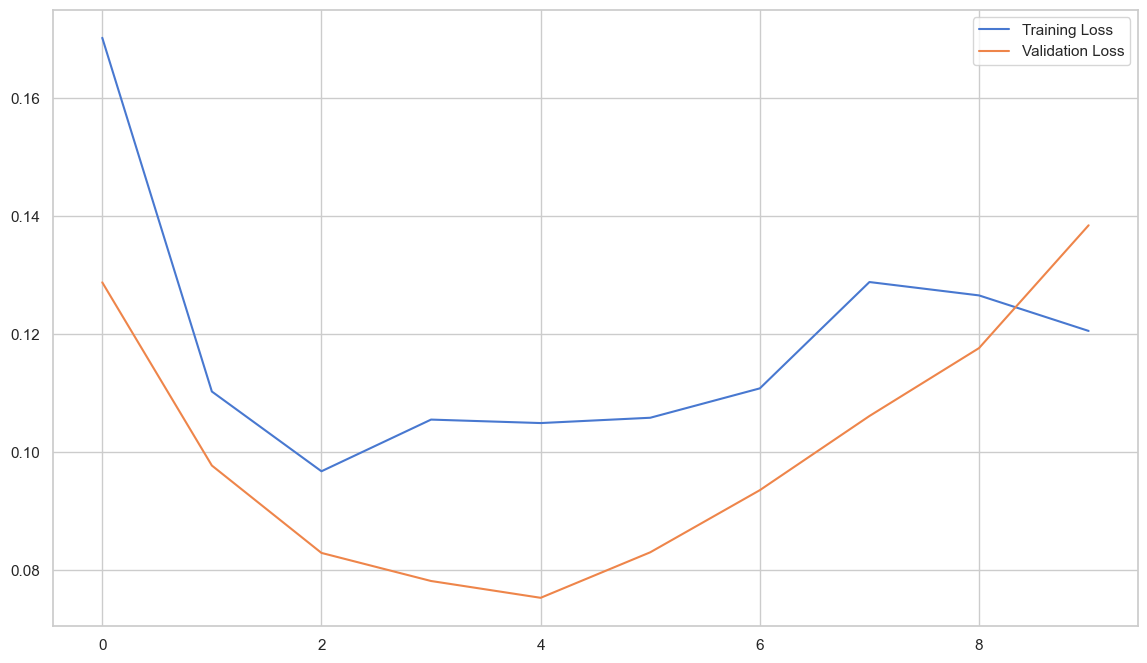

54/54 [==============================] - 1s 9ms/step - loss: 0.5299


/Users/seosang-u/miniforge3/envs/tf2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


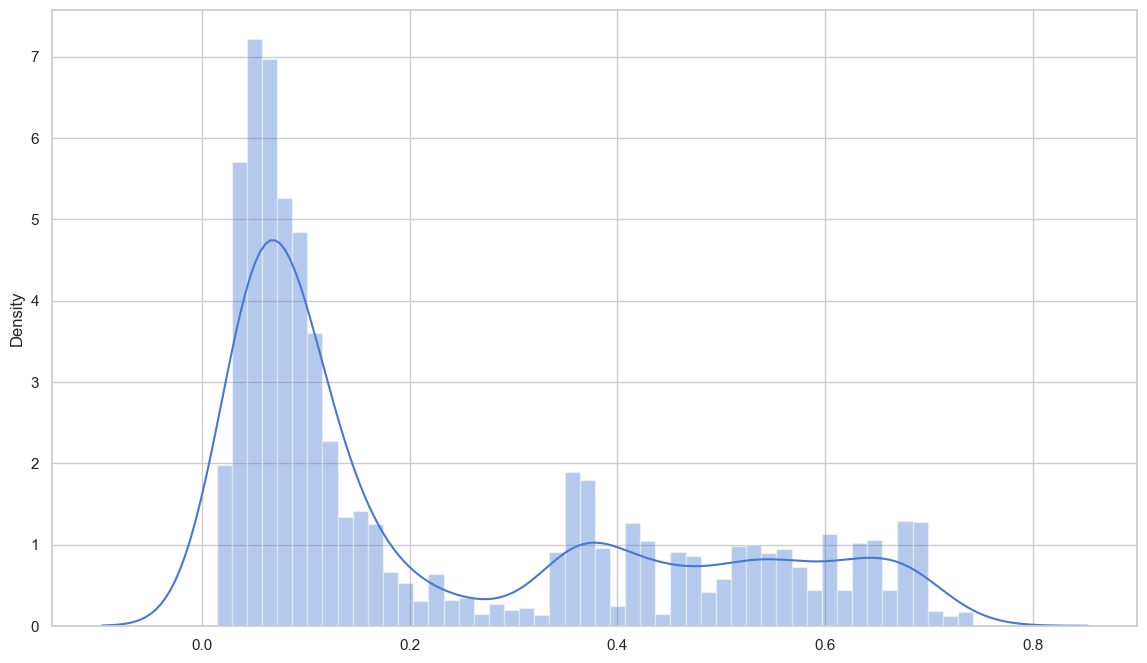

In [8]:
"""

7. Plot Metrics and Evaluate Model

"""

def trainloss_valloss():
    #Lets plot training and validation loss using matplotlib
    #The loss values are stored in history.history (dictionary)
    plt.plot(history.history['loss'], label = 'Training Loss') #Plotting training loss
    plt.plot(history.history['val_loss'], label = 'Validation Loss') #Plotting validation loss
    plt.legend() #Using labels as legend
    #If validation loss is lower than Training loss, it means the model is underfitting. 
    #If validation loss is higher than Training loss, it means the model is overfititng
    return plt.show()

trainloss_valloss() #Plot

#Load the best model observed as saved_model
saved_model = load_model('best_model.h5')


X_train_pred = saved_model.predict(X_train) #Model prediction on training data

#Save Mean Absolute Error to a pandas DataFrame in the Column 'Error'
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis = 1), columns = ['Error'])

#Evaluate the best model, saved_model on test data for total loss. 
saved_model.evaluate(X_test, y_test)

#Lets plot the distribution plot for MAE Loss Error using seaborn
sns.distplot(train_mae_loss, bins = 50, kde = True)

#Lets set a threshold for the MAE Loss. If error is larger, it will be predicted as an anomaly
threshold = 0.50 #This is the value that decides a data point is an anomaly or not. 

#Predict X_test
X_test_pred = saved_model.predict(X_test)

#Store MAE Loss for test data
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)

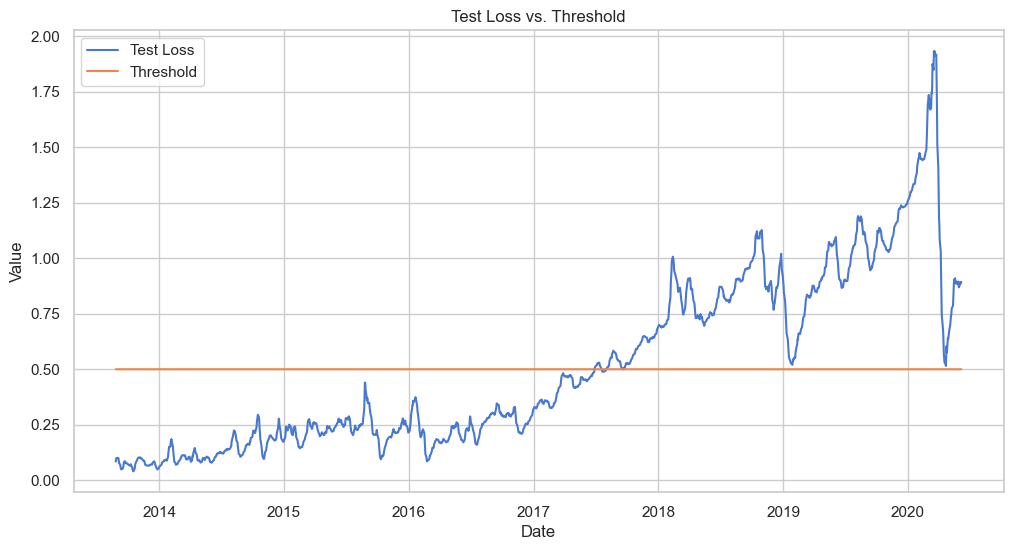

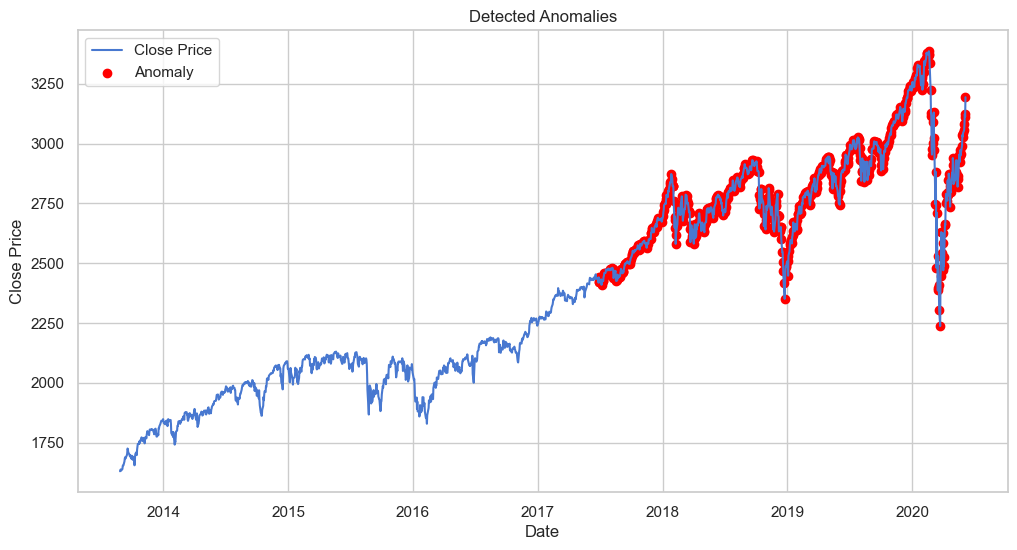

In [10]:
"""

8. Detecting Anomalies in S&P 500 Index Data

"""

#Create DataFrame of losses
test_score_df = pd.DataFrame(test[timesteps:]) #We use the data that comes after time_steps in test data
test_score_df['loss'] = test_mae_loss #Create test_mae_loss column
test_score_df['threshold'] = threshold #Create threshold column
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold #Set anomaly as True if
test_score_df['Close'] = test[timesteps:].Close

#Lets see the newly created DataFrame
test_score_df.head()

#Show the last entries in the dataframe
test_score_df.tail()

def testloss_threshold():
    plt.figure(figsize=(12, 6))
    plt.plot(test[timesteps:].Date, test_score_df.loss, label='Test Loss')
    plt.plot(test[timesteps:].Date, test_score_df.threshold, label='Threshold')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Test Loss vs. Threshold')
    plt.legend()
    plt.show()

testloss_threshold() #Plot

#Lets create a DataFrame for all Anomalies. 
#We create a DataFrame only from True values in the anomaly column
anomalies = test_score_df[test_score_df.anomaly == True] 
anomalies.head()


def show_anomalies():
    plt.figure(figsize=(12, 6))
    plt.plot(test[timesteps:].Date, scaler.inverse_transform(test[timesteps:].Close.values.reshape(-1, 1)), label='Close Price')
    plt.scatter(anomalies.Date, scaler.inverse_transform(anomalies.Close.values.reshape(-1, 1)), color='red', label='Anomaly')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Detected Anomalies')
    plt.legend()
    plt.show()

show_anomalies()  # Show Anomalies